In [1]:
import yt
from yt_experiments.tiled_grid import YTTiledArbitraryGrid, YTPyramid
import matplotlib.pyplot as plt
import numpy as np
import zarr
import os
import shutil

In [2]:
def initialize_store(store_name: str, rm_existing: bool = True):
    """
    initialize a top level on-disk zarr store, optionally
    deleting existing store at the same location. If you
    have the yt test_data_dir set, will initialize at
    test_data_dir / store_name, otherwise will initialize in the
    current directory
    """
    store_dir = yt.config.ytcfg.get("yt", "test_data_dir")
    if store_dir == yt.config.ytcfg_defaults["yt"]["test_data_dir"]:
        store_dir = os.curdir
    store_top = os.path.join(store_dir, store_name)
    if os.path.exists(store_top) and rm_existing:
        shutil.rmtree(store_top)
    zarr_store = zarr.group(store_top)
    return zarr_store

In [3]:
ds = yt.load_sample("DeeplyNestedZoom")

yt : [INFO     ] 2024-08-28 10:39:09,774 Sample dataset found in '/Users/chavlin/data/yt_data/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2024-08-28 10:39:09,933 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2024-08-28 10:39:09,934 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-08-28 10:39:09,934 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-28 10:39:09,934 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-08-28 10:39:09,934 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-08-28 10:39:09,935 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2024-08-28 10:39:09,935 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-08-28 10:39:09,935 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-08-28 10:39:09,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-08-28 10:39:09,935 Parameters: hubb

## optimizing for 2d-slicing : choosing your chunksizes

Optimal chunk sizing will depend on expected data access. For eample, if we plan to visualize axis-aligned 2d slices, we can improve access speed by creating chunks along the expected slicing axis:  

In [4]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge,
    ds.domain_right_edge,
    (2000, 2000, 2000),
    (1, 2000, 2000),
    ds=ds,
)
tag.nchunks

array([2000,    1,    1])

In [5]:
zarr_store = initialize_store("tiled_grid_2d-optimized.zarr")

In [7]:
dens = tag.to_zarr(
    ("gas", "density"),
    zarr_store,
    ops=[
        np.log10,
    ],
)

Parsing Hierarchy : 100%|████████████████████████████████████████████████████████| 1825/1825 [00:00<00:00, 16923.81it/s]
yt : [INFO     ] 2024-08-28 10:39:18,182 Gathering a field list (this may take a moment.)


In [42]:
zarr_store["gas_density"].info

Name,/gas_density
Type,zarr.core.Array
Data type,float64
Shape,"(2000, 2000, 2000)"
Chunk shape,"(1, 2000, 2000)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,64000000000 (59.6G)
No. bytes stored,3227254310 (3.0G)


extracting a single slice in x is quick:

In [8]:
%%time
_ = dens[1000, :, :]

CPU times: user 18 ms, sys: 2.53 ms, total: 20.5 ms
Wall time: 3.22 ms


other access requries concatenation across chunks and so will be signicantly slower

In [9]:
%%time
_ = dens[:, 1000, :]

CPU times: user 35.4 s, sys: 4.72 s, total: 40.1 s
Wall time: 7.83 s


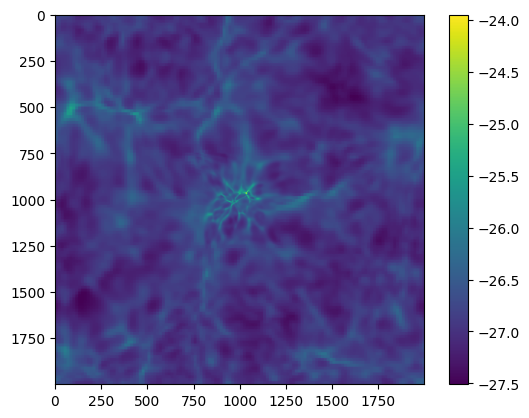

In [10]:
plt.imshow(dens[1000, :, :])
plt.colorbar()

slicing along the chunked access is quick enough that interactive environments like napari will be fully responsive for 2d views (but a note of warning: do not switch to 3d as it will attempt to load the entire 2000x2000x2000 array into memory)

In [13]:
import napari

v = napari.Viewer()

In [15]:
v.add_image(dens, contrast_limits=(-27, -23), colormap="viridis")

<Image layer 'dens' at 0x3276b8a30>

In [16]:
v.close()

or, vizarr

In [20]:
import vizarr
import zarr

viewer = vizarr.Viewer()
viewer.add_image(dens)
viewer

Viewer()

In [21]:
viewer.close()

## optimizing for 3d: pre-applied limits & fills, data type

zarr arrays have the ability to skip writing "empty" chunks to disk where an empty chunk is a chunk for which every value matches a specified fill value. So depending on the use case, there are situations where you can save a bunch of disk space by leveraging this behavior. 

For example, let's say we want to visualize the density field of a cosmological network and know a priori we want to set a lower limit of density in order to highlight the interconnected portions of the domain. So by:

1. using the `ops` keyword argument to `YTTiledArbitraryGrid.to_zarr` (or `.to_array`), we can first apply a lower limit.
2. setting the zarr array to skip empty chunks (by setting `write_empty_chunks=False`) **and** setting a `fill_value` that matches the value we used for the lower limit.

we will skip writing any chunks that match the fill value. For a sparse field writing 3D chunks, this will save a significant amount of disk space (note that it would **not** save any space for the 2-d optimized chunking as it is unlikely a single slice over the whole domain would be empty, at least for the case shown here). 

Furthermore, for interactive 3d visualization, data will generally be downcast to float32. So for creating interactive visualization-ready datasets, we can further save on disk space by downcasting when building the zarr array. 

Finally, note that zarr does offer a lot of flexibility for the [compression used when writing arrays](https://zarr.readthedocs.io/en/stable/tutorial.html#compressors), which we do not touch on here. 

Ok, first, let's illustrate the fill method with a small in-memory array

In [22]:
minvalue = -26.8


def set_lower_limit(values):
    values[values < minvalue] = minvalue
    return values

In [23]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge,
    ds.domain_right_edge,
    (400, 400, 400),
    100,
    ds=ds,
)
vals = tag.to_array(("gas", "density"), ops=[np.log10, set_lower_limit])
print(vals.shape)

(400, 400, 400)


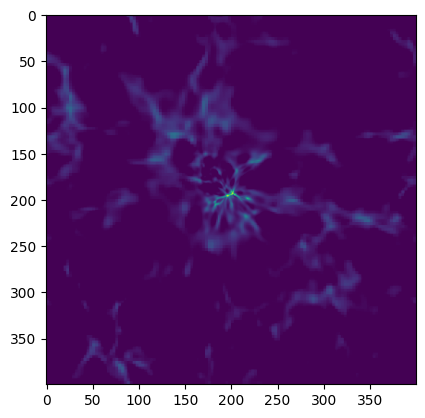

In [24]:
plt.imshow(vals[:, 200, :])

now let's create a large array on-disk

In [28]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge, ds.domain_right_edge, (2048, 2048, 2048), 64, ds=ds
)
tag.nchunks

array([32, 32, 32])

In [29]:
zarr_store = initialize_store("tiled_grid_filled.zarr")

In [30]:
dens = tag.to_zarr(
    ("gas", "density"),
    zarr_store,
    dtype=np.float32,
    ops=[np.log10, set_lower_limit],
    write_empty_chunks=False,
    fill_value=minvalue,
)

In [33]:
zarr_store["gas_density"].info

Name,/gas_density
Type,zarr.core.Array
Data type,float32
Shape,"(2048, 2048, 2048)"
Chunk shape,"(64, 64, 64)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,34359738368 (32.0G)
No. bytes stored,217528789 (207.5M)


and we can see we've stored only 207.5M on disk (compared to 3G for our 2d-optimized slicing, which writes all data at float64). The `Chunks initialized` show that  21669 of the 32768 are initialized, meaning we've skipped writing 11099 chunks. 